<a href="https://colab.research.google.com/github/milantorandria18/Deep_Learning/blob/main/Model_RNN_Shakespeare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import the packages we need for this project

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import string
#import unidecode
import random
import torch
import tensorflow as tf
import platform
import time
import pathlib
import os
from torchtext.data.utils import get_tokenizer

In [2]:
# Force TensorFlow to use GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else:
    print('No GPU available, training on CPU; consider making n_epochs very small.')

Training on GPU!


### Import the data:
The dataset called shakespeare.txt, which contains a poem written by shakespeare

In [4]:
cache_dir = './tmp'
dataset_file_name = 'shakespeare.txt'
dataset_file_origin = 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt'

In [5]:
dataset_file_path = tf.keras.utils.get_file(
    fname = dataset_file_name,
    origin = dataset_file_origin,
    cache_dir = pathlib.Path(cache_dir).absolute()
)

1115394/1115394 [==============================] - 0s 0us/step


In [6]:
text = open(dataset_file_path, mode ='r', encoding = 'utf-8').read()

In [8]:
print(text[:50])

First Citizen:
Before we proceed any further, hear


In [9]:
print("This dataset contains", len(text), "characters")

This dataset contains 1115394 characters


In [10]:
text_sample = text[:10000].split()

In [16]:
print(text_sample)
print(len(text_sample))

['First', 'Citizen:', 'Before', 'we', 'proceed', 'any', 'further,', 'hear', 'me', 'speak.', 'All:', 'Speak,', 'speak.', 'First', 'Citizen:', 'You', 'are', 'all', 'resolved', 'rather', 'to', 'die', 'than', 'to', 'famish?', 'All:', 'Resolved.', 'resolved.', 'First', 'Citizen:', 'First,', 'you', 'know', 'Caius', 'Marcius', 'is', 'chief', 'enemy', 'to', 'the', 'people.', 'All:', 'We', "know't,", 'we', "know't.", 'First', 'Citizen:', 'Let', 'us', 'kill', 'him,', 'and', "we'll", 'have', 'corn', 'at', 'our', 'own', 'price.', "Is't", 'a', 'verdict?', 'All:', 'No', 'more', 'talking', "on't;", 'let', 'it', 'be', 'done:', 'away,', 'away!', 'Second', 'Citizen:', 'One', 'word,', 'good', 'citizens.', 'First', 'Citizen:', 'We', 'are', 'accounted', 'poor', 'citizens,', 'the', 'patricians', 'good.', 'What', 'authority', 'surfeits', 'on', 'would', 'relieve', 'us:', 'if', 'they', 'would', 'yield', 'us', 'but', 'the', 'superfluity,', 'while', 'it', 'were', 'wholesome,', 'we', 'might', 'guess', 'they', 're

For the rest of the analysis, we will focus on the first 10'000 characters

As the puction is also important in the result, we will treat them as a single word

In [12]:
import string

def split_punctuation(words_list):
    result = list()

    for word in words_list:
        for char in string.punctuation:
            word = word.replace(char, " " + char + " ")
        # Supprimer les espaces en trop résultant de l'ajout de ponctuations
        word_1 = word.split()

        if (len(word_1)) == 1:
          result.append(word_1[0])
        else:
          w_1 = word_1[0]
          w_2 = word_1[1]
          result.append(w_1)
          result.append(w_2)

    return result

In [13]:
print(split_punctuation(text_sample))

['First', 'Citizen', ':', 'Before', 'we', 'proceed', 'any', 'further', ',', 'hear', 'me', 'speak', '.', 'All', ':', 'Speak', ',', 'speak', '.', 'First', 'Citizen', ':', 'You', 'are', 'all', 'resolved', 'rather', 'to', 'die', 'than', 'to', 'famish', '?', 'All', ':', 'Resolved', '.', 'resolved', '.', 'First', 'Citizen', ':', 'First', ',', 'you', 'know', 'Caius', 'Marcius', 'is', 'chief', 'enemy', 'to', 'the', 'people', '.', 'All', ':', 'We', 'know', "'", 'we', 'know', "'", 'First', 'Citizen', ':', 'Let', 'us', 'kill', 'him', ',', 'and', 'we', "'", 'have', 'corn', 'at', 'our', 'own', 'price', '.', 'Is', "'", 'a', 'verdict', '?', 'All', ':', 'No', 'more', 'talking', 'on', "'", 'let', 'it', 'be', 'done', ':', 'away', ',', 'away', '!', 'Second', 'Citizen', ':', 'One', 'word', ',', 'good', 'citizens', '.', 'First', 'Citizen', ':', 'We', 'are', 'accounted', 'poor', 'citizens', ',', 'the', 'patricians', 'good', '.', 'What', 'authority', 'surfeits', 'on', 'would', 'relieve', 'us', ':', 'if', 'th

In [17]:
#Apply the function in the whole dataset
text_split = split_punctuation(text.split())
print(len(text_split))
text_list = list(set(text_split))
print(len(text_list))

254793
13152


In [18]:
print(text_split[:10])
print(sorted(text_list))

['First', 'Citizen', ':', 'Before', 'we', 'proceed', 'any', 'further', ',', 'hear']
['!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'ABHORSON', 'ABRAHAM', 'ADRIAN', 'AEacides', 'AEdile', 'AEdiles', 'AEneas', 'AEsop', 'ALL', 'ALONSO', 'ANGELO', 'ANNE', 'ANOTHER', 'ANTIGONUS', 'ANTONIO', 'ARCHBISHOP', 'ARCHIDAMUS', 'ARIEL', 'AUFIDIUS', 'AUMERLE', 'AUTOLYCUS', 'Abase', 'Abate', 'Abated', 'Abbot', 'Abel', 'Abhorred', 'Abhorson', 'Abides', 'Able', 'About', 'Above', 'Abraham', 'Absolute', 'Accept', 'Accomplish', 'According', 'Accords', 'Account', 'Accountant', 'Accursed', 'Accuse', 'Achieve', 'Acquaint', 'Action', 'Adam', 'Add', 'Added', 'Adding', 'Address', 'Adieu', 'Adjudged', 'Admit', 'Adonis', 'Adoptedly', 'Adopts', 'Adrian', 'Adriatic', 'Advance', 'Advantaging', 'Adversity', 'Advertising', 'Advocate', 'Affection', 'Affliction', 'Affrighted', 'Affrights', 'Affront', 'Afore', 'Afresh', 'Afric', 'African', 'After', 'Again', 'Against', 'Agamemnon', 'Age', 'Aged', 'Agenor', 'Agr

In [21]:
trigrams = [([text_split[i], text_split[i + 1]], text_split[i + 2])
            for i in range(len(text_split) - 2)]
chunk_len=len(trigrams)
print(trigrams[:30])
print(chunk_len)

[(['First', 'Citizen'], ':'), (['Citizen', ':'], 'Before'), ([':', 'Before'], 'we'), (['Before', 'we'], 'proceed'), (['we', 'proceed'], 'any'), (['proceed', 'any'], 'further'), (['any', 'further'], ','), (['further', ','], 'hear'), ([',', 'hear'], 'me'), (['hear', 'me'], 'speak'), (['me', 'speak'], '.'), (['speak', '.'], 'All'), (['.', 'All'], ':'), (['All', ':'], 'Speak'), ([':', 'Speak'], ','), (['Speak', ','], 'speak'), ([',', 'speak'], '.'), (['speak', '.'], 'First'), (['.', 'First'], 'Citizen'), (['First', 'Citizen'], ':'), (['Citizen', ':'], 'You'), ([':', 'You'], 'are'), (['You', 'are'], 'all'), (['are', 'all'], 'resolved'), (['all', 'resolved'], 'rather'), (['resolved', 'rather'], 'to'), (['rather', 'to'], 'die'), (['to', 'die'], 'than'), (['die', 'than'], 'to'), (['than', 'to'], 'famish')]
254791


In [43]:
trigrams = trigrams[:25000]
chunk_len=len(trigrams)

In [35]:
#Create a dictionary which give every single word an index, that we will use in the data set
vocab = set(text_split)
voc_len=len(vocab)
word_to_ix = {word: i for i, word in enumerate(vocab)}

In [36]:
print(word_to_ix)

{'Deserved': 0, 'coverture': 1, 'attires': 2, 'liking': 3, 'abstains': 4, 'unrespective': 5, 'Christmas': 6, 'servanted': 7, 'unknit': 8, 'Once': 9, 'sincerely': 10, 'excused': 11, 'Thorough': 12, 'dangers': 13, 'gains': 14, 'wooers': 15, 'gracious': 16, 'fare': 17, 'swelling': 18, 'Woe': 19, 'Near': 20, 'gape': 21, 'sauce': 22, 'sliding': 23, 'importune': 24, 'extirpate': 25, 'oddest': 26, 'Glendower': 27, 'seduce': 28, 'Confound': 29, 'Devouring': 30, 'Plays': 31, 'loves': 32, 'handsomely': 33, 'farewell': 34, 'mutinies': 35, 'LAURENCE': 36, 'frailty': 37, 'Sweet': 38, 'forlorn': 39, 'cream': 40, 'vice': 41, 'crowning': 42, 'fringed': 43, 'executioners': 44, 'gravel': 45, 'mans': 46, 'weakest': 47, 'quivering': 48, 'Duck': 49, 'squared': 50, 'Rice': 51, 'alehouse': 52, 'poultice': 53, 'remember': 54, 'attainder': 55, 'Gallia': 56, 'Together': 57, 'Kated': 58, 'knowest': 59, 'inaccessible': 60, 'signs': 61, 'invested': 62, 'Present': 63, 'together': 64, 'doubt': 65, 'Nearer': 66, 'fif

In [37]:
#Convert the word into number based on the index
inp=[]
tar=[]
for context, target in trigrams:
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
        inp.append(context_idxs)
        targ = torch.tensor([word_to_ix[target]], dtype=torch.long)
        tar.append(targ)

In [38]:
print(len(inp))
print(inp[:20])

25000
[tensor([  776, 10485]), tensor([10485,  4168]), tensor([4168, 2653]), tensor([ 2653, 12979]), tensor([12979, 11111]), tensor([11111,  1919]), tensor([1919, 5756]), tensor([5756,  269]), tensor([  269, 10151]), tensor([10151,  3873]), tensor([ 3873, 11390]), tensor([11390,  8629]), tensor([8629, 3782]), tensor([3782, 4168]), tensor([4168, 9743]), tensor([9743,  269]), tensor([  269, 11390]), tensor([11390,  8629]), tensor([8629,  776]), tensor([  776, 10485])]


In [39]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size*2, hidden_size, n_layers,batch_first=True,
                          bidirectional=False)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [40]:
def train(inp, target):
    hidden = decoder.init_hidden().cuda()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c].cuda(), hidden)
        loss += criterion(output, target[c].cuda())

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / chunk_len

In [41]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [44]:
n_epochs = 100
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.015

decoder = RNN(voc_len, hidden_size, voc_len, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0
if(train_on_gpu):
    decoder.cuda()
for epoch in range(1, n_epochs + 1):
    loss = train(inp,tar)
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 50, loss))
#         print(evaluate('ge', 200), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 55s (100 50%) 0.9177]


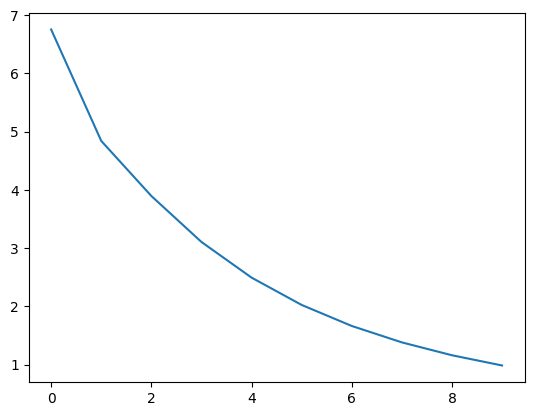

In [45]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

In [46]:
def evaluate(prime_str='we speak', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden().cuda()

    for p in range(predict_len):

        prime_input = torch.tensor([word_to_ix[w] for w in prime_str.split()], dtype=torch.long).cuda()
        inp = prime_input[-2:] #last two words as input
        output, hidden = decoder(inp, hidden)

        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Add predicted word to string and use as next input
        predicted_word = list(word_to_ix.keys())[list(word_to_ix.values()).index(top_i)]
        prime_str += " " + predicted_word
#         inp = torch.tensor(word_to_ix[predicted_word], dtype=torch.long)

    return prime_str

In [48]:
print(evaluate('you speak', 100, temperature=1.2))

you speak Aufidius fortune ? Second Officer : I ' leave you . VOLUMNIA : Do his gods For our city , Titus , I am out of hope like a hare . MARCIUS : Go to her friends , you Anon have ' hear our say not think to fob off our disgrace with a tale , Some trick not worth an egg , shall within this hour , On a dissension of some popular man and one infect another Against the wind this night home , That every noble of our more with a voice , I ' beseech you


In [49]:
print(evaluate('you speak', 100, temperature=0.5))

you speak of now , Or never trust to what all the horses , Whereof we have ta ' good with a respect more tender , More holy and profound , than mine own life : for the people , bonneted , without any further deed to set dogs on sheep - be better as do his country service . First Citizen : You have stood them , and do so . SICINIUS : Let ' hear it , as you are reverend grave men , how you are reverend grave men , I pray you , which you profane , Never


In [55]:
print(evaluate('ROMEO :', 100, temperature=1.2))

ROMEO : Thou hast gentle crab ! have here him saw As at Tullus this bonnet in thy solemness corn - This were absolute ; Though therein you can to the spire and no more voice chase , fellow like to thy hand ; And four doubt Fine he caught it , You , but mock ' . CORIOLANUS : How ? met thou Do fair man . VIRGILIA : Heavens bless my lord ; and come home beloved Of all his good common people , I may be sworn but , Here has it , A brand to the end o


AttributeError: ignored